# CNN Cancer Detection Kaggle Mini-Project

## Brief description of the problem and data 

In this mini-project, we shall use **binary classification** to classify an image into cancerous (class label $1$) or benign (class label $0$), i.e., to identify metastatic cancer in small image patches taken from larger digital pathology scans (this problem is taken from a past Kaggle completition). 

PCam packs the clinically-relevant task of metastasis detection into a straight-forward **binary image classification** task, which the CNN model performs. The CNN Model is trained on Colab GPU on a given set of images and then it predicts / detects tumors in a set of unseen test images. 

The dataset provides a large number of small pathology images to classify. Files are named with an image `id`. The `train_labels.csv` file provides the ground truth for the images in the train folder. The goal is to predict the labels for the images in the test folder. A positive label indicates that the center $32\times 32$px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

## Exploratory Data Analysis (EDA)

First we need to import all `python` packages / functions that are required for building the CNN model. We shall use `tensorflow / keras` to train the deep learning model. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import visualkeras
from tifffile import imread
from skimage import draw

As can be seen, the number of images in training folder (ones with ground-truth labels) and test folders (without ground-truth labels) are around 220k and 57k, respectively.

In [2]:
# count number of training and test images
base_dir = 'histopathologic-cancer-detection'
train_dir, test_dir = f'{base_dir}/train/', f'{base_dir}/test/'
ntrain, ntest = len(os.listdir(train_dir)), len(os.listdir(test_dir))
print(f'#training images = {ntrain}, #test inages={ntest}')

#training images = 220025, #test inages=57458


The `train_labels.csv` file is loaded as a `pandas` `DataFrame` (first few rows of the dataframe are shown below). It contains the `id` of the `tif` image files from the training folder, along with their ground-truth label. Let's have the file names in the `id` column instead, by concatenating the `.tif` extension to the `id` values. It will turn out to be useful later while reading the files from the folder automatically. 

In [3]:
# read the training images and ground truth labels into a dataframe
train_df = pd.read_csv(f'{base_dir}/train_labels.csv')
train_df['label'] = train_df['label'].astype(str)
train_df['id'] = train_df['id'] + '.tif'
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The images are RGB color images of shape $96 \times 96$, as seen from the next code snippet, the images are loaded using `tif` `imread()` function.

In [12]:
imread(f'{train_dir}/{train_df.id[0]}').shape

(96, 96, 3)

Also, as can be seen from below plot, there are around 130k benign and 89k cancerous images in the trainign dataset, hence the dataset is not very imbalanced, also the data size is large. Hence we are not using augmentation like preprocessing steps.

0    130908
1     89117
Name: label, dtype: int64

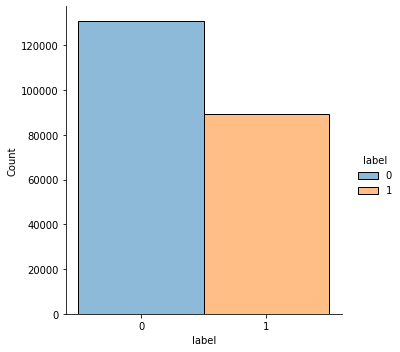

In [ ]:
# histogram of class labels
sns.displot(data=train_df, x='label', hue='label')
train_df['label'] = train_df['label'].astype(int)
train_df['label'].value_counts()

Next let's plot 100 randomly selected bening and cancerous images (with label 0 and 1, respectively, by highlighting the center 32x32 region) from training dataset to visually inspect the difference, if any.

In [ ]:
def plot_images(df, label, n=100):
    row, col = draw.rectangle_perimeter(start=(96//2-32//2,96//2-32//2), end=(96//2+32//2,96//2+32//2))
    df_sub = df.loc[df.label == label].sample(n)
    imfiles = df_sub['id'].values
    plt.figure(figsize=(15,15))
    for i in range(n):
        im = imread(f'{train_dir}/{imfiles[i]}')
        for j in range(-1,2):
            im[row+j, col+j, :] = [0, 255, 0]
        plt.subplot(10,10,i+1)
        plt.imshow(im)
        plt.axis('off')
    plt.suptitle(f'sample train images with label = {label} (highlighting the center 32x32 region)', size=20)
    plt.tight_layout()
    plt.show()

# sample and plot images from different classes
for label in train_df.label.unique():
    plot_images(train_df, label)

![](images/cells_0.png)
![](images/cells_1.png)

## Preprocessing

* The image pixels will be scaled (normalized) in the range $[0-1]$, it will be done during the batch reading of the images.
* Resize the $96\times 96$ images to size $64 \times 64$, to reduce the memory.
* The dataset is not very imbalanced, also the data size is large. Hence we are not using augmentation like preprocessing steps.

## Model Architecture

Quite a few models were trained to classify the images, starting from simpler baseline models to more complex models.

## Baseline Models

We shall first implement a couple of baseline models using `keras` *model subclassing* with *configurable* *reusable blocks* (so that we can reuse them and change the *hyperparameters*) and *functional APIs*. 

* The models will be traditional *CNN* models, which will comprise of a few Convolution/Pooling blocks (to obtain translation invariance, increase field of view, reduce number of parameters etc.) followed by flatten, Dense a binary classification layer. 

* There will be a Convolution Block implemented by the class `ConvBlock` which will contain 2 `Conv2D` layers of same size followed by a `MaxPool2D` layer. There can be an optional `BatchNormalization` layer (to reduce *internal covariate shift* between the batches) immediately following each fo the the `Conv2D` layers. The filter size, kernel size, activation, pooling size and whether batch norm will be present or not will be configurable (with default values) and can be specified during instantiation of the block.

* The next reusable block will be the `TopBlock` that will contain a Flatten layer followed by two dense layers, the last of which will be classification layer, which will have a single output neuron. The size of the dense layer will be configurable.

* By default `ReLU` non-linear activation will be used in the layers, except in the last classifier layer, which will use `sigmoid` activation (to keep the output in the range $[0-1]$, that can be interpreted as probability whether an image contains tumor cells or not).

The baseline model architecture shown below:

![](images/model1.png)

The `batch_size` and `im_size` will also be hyperparameters that can be tuned / changed. We shall use batch size of 256 and all the images will be resized to $64 \times 64$, in order to save memory.

In [2]:
batch_size, im_size = 256, 64

In [3]:
class ConvBlock(tf.keras.layers.Layer):
    '''
    implements CovBlock as
    Conv2D -> Conv2D -> MaxPool OR
    Conv2D -> BatchNorm -> Conv2D -> BatchNorm -> MaxPool 
    as a reusable block in the CNN to be created
    '''
    def __init__(self, n_filter, kernel_sz=(3,3), activation='relu', pool_sz=(2,2), batch_norm=False):
        # initialize with different hyperparamater values such as number of filters in Conv2D, kernel size, activation
        # BatchNorm present or not
        super(ConvBlock, self).__init__()
        self.batch_norm = batch_norm
        self.conv_1 = Conv2D(n_filter, kernel_sz, activation=activation)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(n_filter, kernel_sz, activation=activation)
        self.bn_2 = BatchNormalization()
        self.pool = MaxPool2D(pool_size=pool_sz)

    def call(self, x):
        # forward pass
        x = self.conv_1(x)
        if self.batch_norm:
          x = self.bn_1(x)
          x = tf.keras.layers.ReLU()(x)
        x = self.conv_2(x)
        if self.batch_norm:
          x = self.bn_2(x)
          x = tf.keras.layers.ReLU()(x)
        return self.pool(x)

class TopBlock(tf.keras.layers.Layer):
    '''
    implements the top layer of the CNN
    Flatten -> Dense -> Classification
    as a reusable block
    '''
    def __init__(self, n_units=256, activation='relu', drop_out=False, drop_rate=0.5):
        # initialize the block with configurable hyperparameter values, e.g., number of neurons in Dense block, activation
        # Droput present or not
        super(TopBlock, self).__init__()
        self.drop_out = drop_out
        self.flat  = tf.keras.layers.Flatten()
        self.dropout = Dropout(drop_rate)
        self.dense = tf.keras.layers.Dense(n_units, activation=activation)
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False):
        # forward pass
        x = self.flat(x)
        #if training:
        #  x = self.dropout(x)
        x = self.dense(x)
        return self.classifier(x)

We shall create couple of models by tuning the hyperparameters `Conv2D` filtersize and `Dense` layersize, with / without normalization:

### CNNModel1

* `CNNModel1`: the first one without `BatchNormalization` and ConvBlock sizes $16$, $32$, respectively and dense layer size $256$, as shown in the next code snippet.

In [7]:
class CNNModel1(tf.keras.Model):
    def __init__(self, input_shape=(im_size,im_size,3), n_class=1):
        super(CNNModel1, self).__init__()
        # the first conv module
        self.conv_block_1 = ConvBlock(16)
        # the second conv module
        self.conv_block_2 = ConvBlock(32)
        # model top
        self.top_block = TopBlock(n_units=256)

    def call(self, inputs, training=False, **kwargs):
        # forward pass 
        x = self.conv_block_1(inputs)
        x = self.conv_block_2(x)
        return self.top_block(x)       

# instantiate and build the model without BatchNorm
model1 = CNNModel1()
model1.build(input_shape=(batch_size,im_size[0],im_size[1],3))
model1.summary()

Model: "base_model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      multiple                  2768      
                                                                 
 conv_block_1 (ConvBlock)    multiple                  14144     
                                                                 
 top_block (TopBlock)        multiple                  1384961   
                                                                 
Total params: 1,401,873
Trainable params: 1,401,745
Non-trainable params: 128
_________________________________________________________________


The model architecutre looks like the following (the model can be defined using `keras` `Sequential` too):

![](images/model_plot.png)    

### CNNModel2

* `CNNModel2`: the second one with `BatchNormalization` and ConvBlock sizes $32$, $32$, respectively and dense layer size $512$, defined / instantiated using the next code snippet. 

In [9]:
class CNNModel2(tf.keras.Model):
    def __init__(self, input_shape=(im_size,im_size,3), n_class=1):
        super(CNNModel2, self).__init__()
        # the first conv module
        self.conv_block_1 = ConvBlock(32, batch_norm=True)
        # the second conv module
        self.conv_block_2 = ConvBlock(32, batch_norm=True)
        # model top
        self.top_block = TopBlock(n_units=512)

    def call(self, inputs, training=False, **kwargs):
        # forward pass 
        x = self.conv_block_1(inputs)
        x = self.conv_block_2(x)
        return self.top_block(x)       

# instantiate and build the model with BatchNorm
model2 = CNNModel2()
model2.build(input_shape=(batch_size,im_size,im_size,3))
model2.summary()

Model: "base_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_2 (ConvBlock)    multiple                  10400     
                                                                 
 conv_block_3 (ConvBlock)    multiple                  18752     
                                                                 
 top_block_1 (TopBlock)      multiple                  2769921   
                                                                 
Total params: 2,799,073
Trainable params: 2,798,817
Non-trainable params: 256
_________________________________________________________________


We shall also use couple of popular architectures, namely, VGG16, VGG19 and ResNet50 and add a couple of layers with the models by removing the top layer, for the classfication.

## Model with VGG16 Backbone

In [13]:
base_model = tf.keras.applications.VGG16(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

#color_map = get_color_map()
#visualkeras.layered_view(base_model, color_map=color_map, legend=True)

![vgg16.png](images/vgg16.png)

In [31]:
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg16_backbone')
model_vgg16.summary()

Model: "vgg16_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 4608)             18432     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 16)                73744     
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                    

## Model with VGG19 Backbone

In [ ]:
base_model = tf.keras.applications.VGG19(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)
#color_map = get_color_map()
#visualkeras.layered_view(base_model, color_map=color_map, legend=True)

![vgg19.png](images/vgg19.png)

In [15]:
np.random.seed(1)
tf.random.set_seed(1)

model_vgg19 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg19_backbone')

model_vgg19.summary()

Model: "vgg19_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 4608)             18432     
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 16)                73744     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                    

## Model with ResNet50 Backbone

In [14]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)
#color_map = get_color_map()
#visualkeras.layered_view(base_model, color_map=color_map, legend=True)

94765736/94765736 [==============================] - 1s 0us/step


![resnet50.png](images/resnet50.png)

In [15]:
np.random.seed(1)
tf.random.set_seed(1)

model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'resnet50_backbone')

model_resnet50.summary()

Model: "resnet50_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 18432)            73728     
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                294928    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                 

Now, we need to read the images, to do this automatically during the training phase, we shall use `ImageDataGenerator` with the `flow_from_dataframe()` method and hold-out 25% of the training images for validation performance evaluation.

In [7]:
# scale the images to have pixel values in between [0-1]
# create 75-25 train-validation split of the training dataset for model evaluation
generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_data = generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)

val_data = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## Results and Analysis 

The model without the `BatchNormalization` layers is first trained. `Adam` optimizer is used with `learning_rate=0.001` (higher learning rates seems to diverge), with loss function as *BCE* (`binary_crossentropy`) and trained for 10 epochs. We shall use the `BCE` `loss` and `accuracy` metrics on the held-out validation dataset for model evaluation.

## Results with Baseline Models

### With CNNModel1 

In [ ]:
# compile and fit the first model with Adam optimizer, BCE loss and to be evaluated with accuracy metric
opt = Adam(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
645/645 [==============================] - 465s 702ms/step - loss: 0.4813 - accuracy: 0.7729 - val_loss: 0.4514 - val_accuracy: 0.7940
Epoch 2/10
645/645 [==============================] - 313s 486ms/step - loss: 0.4457 - accuracy: 0.7974 - val_loss: 0.4334 - val_accuracy: 0.8033
Epoch 3/10
645/645 [==============================] - 295s 458ms/step - loss: 0.4254 - accuracy: 0.8090 - val_loss: 0.4130 - val_accuracy: 0.8156
Epoch 4/10
645/645 [==============================] - 304s 472ms/step - loss: 0.4085 - accuracy: 0.8181 - val_loss: 0.4145 - val_accuracy: 0.8127
Epoch 5/10
645/645 [==============================] - 293s 454ms/step - loss: 0.3970 - accuracy: 0.8232 - val_loss: 0.4027 - val_accuracy: 0.8197
Epoch 6/10
645/645 [==============================] - 307s 476ms/step - loss: 0.3859 - accuracy: 0.8291 - val_loss: 0.3780 - val_accuracy: 0.8340
Epoch 7/10
645/645 [==============================] - 298s 462ms/step - loss: 0.3756 - accuracy: 0.8343 - val_loss: 0.3716 -

As can be seen, the validation loss went as low as 0.3611 and validation accuracy went upto 84%. The next figure shows how both the training and validation loss decreased over epochs, whereas both the training and validation accuracy increased  steadily over epochs during training, with the model.

In [8]:
def plot_hist(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.legend(["Accuracy","Validation Accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["Loss","Validation Loss"])
    plt.tight_layout()
    plt.show()

In [ ]:
plot_hist(hist)

![](images/loss_model1.png)

### with CNNModel2

Next we tried the model with batch normalization enabled and the other hyperparameters tune, as described above. The optimizer and number of epochs used were same as above.

In [12]:
# compile and fit the second model with Adam optimizer, BCE loss and to be evaluated with accuracy metric
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(data_train, validation_data=data_validate, epochs=10)

Epoch 1/10
645/645 [==============================] - 339s 524ms/step - loss: 0.4674 - accuracy: 0.7898 - val_loss: 0.5076 - val_accuracy: 0.7524
Epoch 2/10
645/645 [==============================] - 295s 457ms/step - loss: 0.3545 - accuracy: 0.8459 - val_loss: 0.4115 - val_accuracy: 0.8156
Epoch 3/10
645/645 [==============================] - 290s 450ms/step - loss: 0.3094 - accuracy: 0.8687 - val_loss: 0.4750 - val_accuracy: 0.7899
Epoch 4/10
645/645 [==============================] - 296s 458ms/step - loss: 0.2780 - accuracy: 0.8837 - val_loss: 0.2989 - val_accuracy: 0.8750
Epoch 5/10
645/645 [==============================] - 295s 457ms/step - loss: 0.2524 - accuracy: 0.8958 - val_loss: 0.3228 - val_accuracy: 0.8658
Epoch 6/10
645/645 [==============================] - 295s 457ms/step - loss: 0.2236 - accuracy: 0.9088 - val_loss: 0.3009 - val_accuracy: 0.8763
Epoch 7/10
645/645 [==============================] - 292s 453ms/step - loss: 0.1917 - accuracy: 0.9246 - val_loss: 0.3610 -

As can be seen, the validation loss went to 0.4302 and validation accuracy went upto 85%. The next figure shows how both the training loss / accuracy steadily decreased / increased over epochs, resepectively, but the validation loss / accuracy became unstable.

In [ ]:
plot_hist(hist)

![](images/loss_model2.png)

## Results with the model with VGG16 backbone

We shall attempt transfer learning / fine tuning (by starting with pretrained weights on imagenet and keeping the VGG16 backbone weights frozen) and also train VGG16 from scratch and compare the results obtained in terms of accuracy and **ROC AUC** (area under the curve). 

### Transfer Learning / Fine Tuning

In [32]:
opt = tf.keras.optimizers.Adam(0.001)
base_model.trainable = False
model_vgg16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model_vgg16.fit(train_data, epochs = 20, validation_data = val_data, verbose=1)

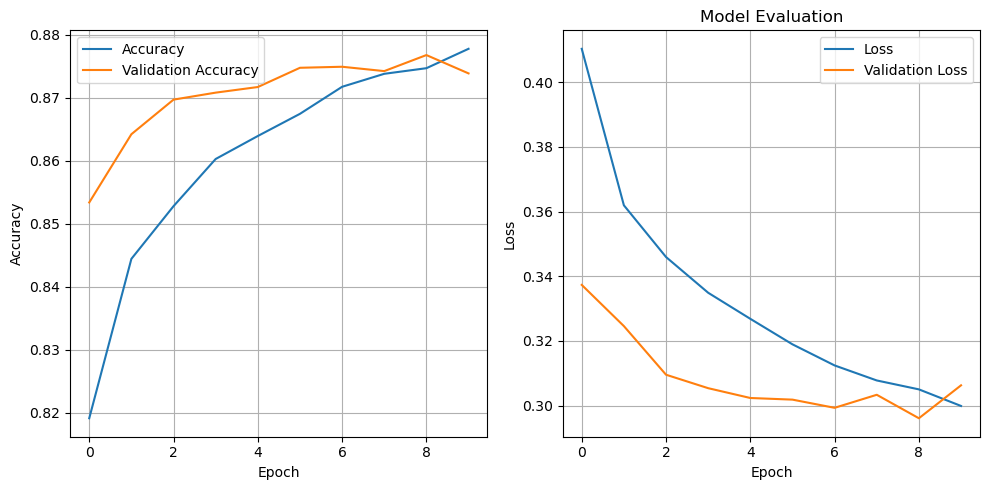

In [18]:
plot_hist(hist)

### Training from Scratch

In [34]:
base_model.trainable = True
model_vgg16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [35]:
%%time 
hist = model_vgg16.fit(train_data, epochs = 20, validation_data = val_data, verbose=1)

Epoch 1/20
645/645 [==============================] - 867s 1s/step - loss: 0.5446 - accuracy: 0.7338 - auc_6: 0.7940 - val_loss: 0.5420 - val_accuracy: 0.7202 - val_auc_6: 0.7990
Epoch 2/20
645/645 [==============================] - 524s 812ms/step - loss: 0.5008 - accuracy: 0.7689 - auc_6: 0.8329 - val_loss: 0.9227 - val_accuracy: 0.6275 - val_auc_6: 0.7825
Epoch 3/20
645/645 [==============================] - 543s 842ms/step - loss: 0.4721 - accuracy: 0.7896 - auc_6: 0.8551 - val_loss: 0.5896 - val_accuracy: 0.7274 - val_auc_6: 0.8574
Epoch 4/20
645/645 [==============================] - 544s 842ms/step - loss: 0.4151 - accuracy: 0.8228 - auc_6: 0.8908 - val_loss: 156.7007 - val_accuracy: 0.6567 - val_auc_6: 0.8239
Epoch 5/20
645/645 [==============================] - 534s 828ms/step - loss: 0.3698 - accuracy: 0.8484 - auc_6: 0.9156 - val_loss: 0.3955 - val_accuracy: 0.8148 - val_auc_6: 0.9197
Epoch 6/20
645/645 [==============================] - 517s 802ms/step - loss: 0.3137 - accu

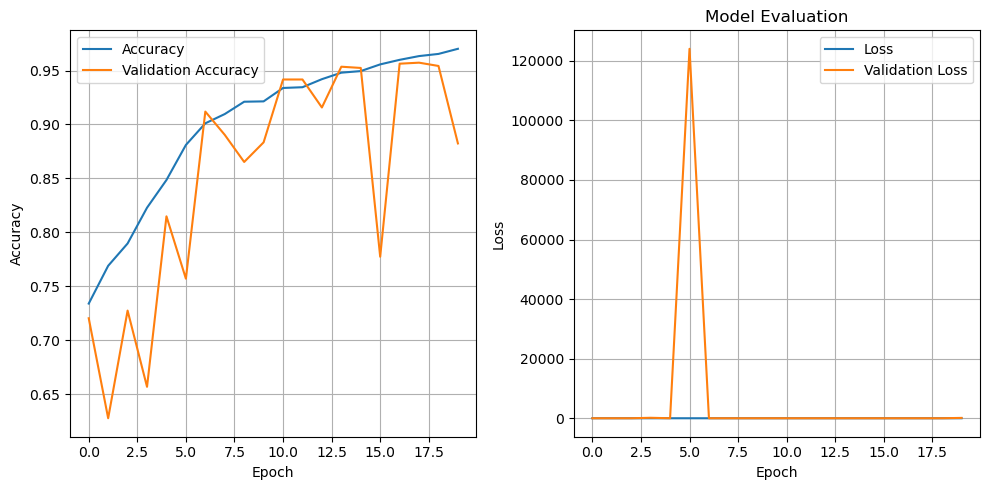

In [36]:
plot_hist(hist)

## Results with the model with VGG19 Backbone

This is the model that performed best and obtained ~88% public ROC score on the unseen test dataset.

### Training from Scratch

In [16]:
opt = tf.keras.optimizers.Adam(0.001)
base_model.trainable = True
model_vgg19.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [17]:
%%time 
hist = model_vgg19.fit(train_data, epochs = 20, validation_data = val_data, verbose=1)

Epoch 1/20
645/645 [==============================] - 1362s 2s/step - loss: 0.5519 - accuracy: 0.7240 - auc_1: 0.7850 - val_loss: 1294.4092 - val_accuracy: 0.7835 - val_auc_1: 0.8600
Epoch 2/20
645/645 [==============================] - 585s 907ms/step - loss: 0.4525 - accuracy: 0.7966 - auc_1: 0.8673 - val_loss: 1.1149 - val_accuracy: 0.6579 - val_auc_1: 0.7463
Epoch 3/20
645/645 [==============================] - 557s 863ms/step - loss: 0.3838 - accuracy: 0.8365 - auc_1: 0.9082 - val_loss: 1.0965 - val_accuracy: 0.7396 - val_auc_1: 0.7908
Epoch 4/20
645/645 [==============================] - 557s 864ms/step - loss: 0.3291 - accuracy: 0.8682 - auc_1: 0.9331 - val_loss: 0.5429 - val_accuracy: 0.7161 - val_auc_1: 0.9106
Epoch 5/20
645/645 [==============================] - 555s 859ms/step - loss: 0.2725 - accuracy: 0.8989 - auc_1: 0.9540 - val_loss: 0.2246 - val_accuracy: 0.9134 - val_auc_1: 0.9708
Epoch 6/20
645/645 [==============================] - 555s 860ms/step - loss: 0.2316 - ac

In [18]:
model_vgg19.save('model_vgg19_20.h5')

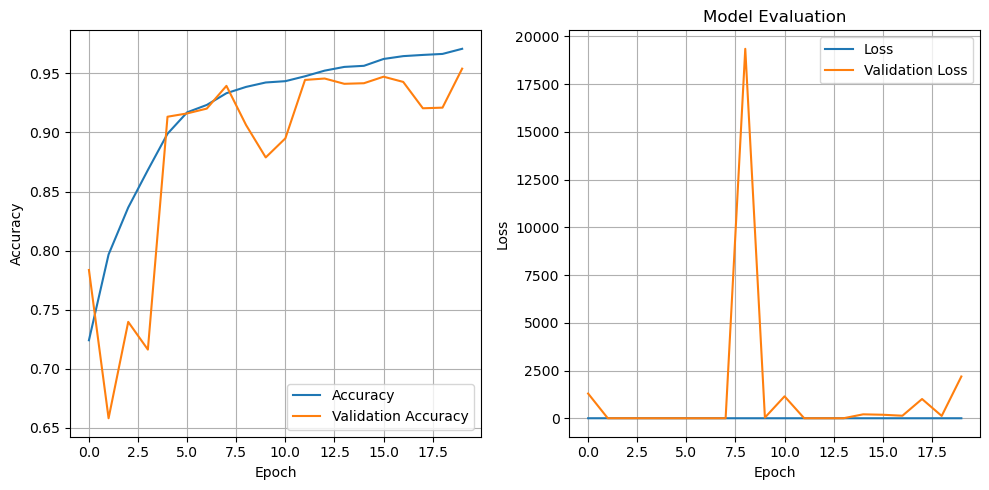

In [19]:
plot_hist(hist)

## Results with the model with ResNet50 Backbone

In [16]:
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.001)
model_resnet50.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [17]:
%%time 
hist = model_resnet50.fit(train_data, validation_data=val_data, epochs=20, verbose=1)

Epoch 1/20
645/645 [==============================] - 1317s 2s/step - loss: 0.3414 - accuracy: 0.8588 - auc: 0.9298 - val_loss: 1.1011 - val_accuracy: 0.5951 - val_auc: 0.3934
Epoch 2/20
645/645 [==============================] - 593s 919ms/step - loss: 0.2412 - accuracy: 0.9122 - auc: 0.9653 - val_loss: 0.5169 - val_accuracy: 0.8323 - val_auc: 0.9167
Epoch 3/20
645/645 [==============================] - 450s 697ms/step - loss: 0.2124 - accuracy: 0.9235 - auc: 0.9722 - val_loss: 0.2642 - val_accuracy: 0.8980 - val_auc: 0.9597
Epoch 4/20
645/645 [==============================] - 448s 695ms/step - loss: 0.1941 - accuracy: 0.9305 - auc: 0.9766 - val_loss: 0.3500 - val_accuracy: 0.8499 - val_auc: 0.9337
Epoch 5/20
645/645 [==============================] - 446s 692ms/step - loss: 0.1791 - accuracy: 0.9353 - auc: 0.9795 - val_loss: 0.6030 - val_accuracy: 0.7776 - val_auc: 0.8575
Epoch 6/20
645/645 [==============================] - 449s 696ms/step - loss: 0.1673 - accuracy: 0.9416 - auc: 0

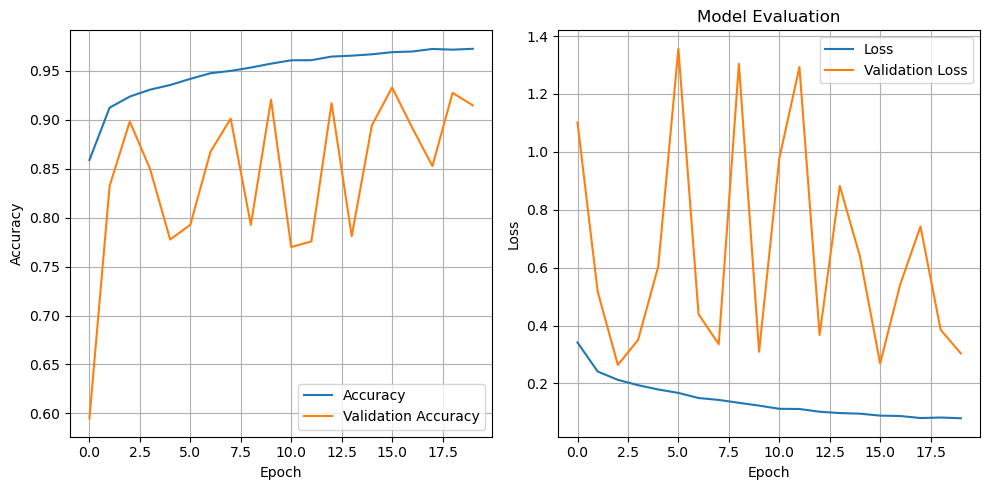

In [18]:
plot_hist(hist)

As seen from the above figure, the ResNet50 model's accuracy and loss both are quite fluctuating not stable and need more training.

## Predictions on test images

Again a dataframe with test image ids were stored in a dataframe and the test images were automatically read during rediction phase with the function `flow_from_dataframe()`, as before. The predictions are submitted to *kaggle* to obtain the score (although leaderboard selection was disabled).

In [15]:
import os
images_test = pd.DataFrame({'id':os.listdir(test_dir)})
generator_test = ImageDataGenerator(rescale=1./255) # scale the test images to have pixel values in [0-1]

test_data = generator_test.flow_from_dataframe(
    dataframe = images_test,
    x_col='id', # filenames
    directory=test_dir,
    class_mode=None,
    batch_size=1,
    target_size=im_size,
    shuffle=False)

# predict with the model
predictions = model1.predict(test_data, verbose=1)

Found 57458 validated image filenames.
57458/57458 [==============================] - 209s 4ms/step


In [16]:
predictions = predictions.squeeze()
predictions.shape

(57458,)

In [17]:
# create submission dataframe for kaggle submission
submission_df = pd.DataFrame()
submission_df['id'] = images_test['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

submission_df['label'].value_counts()
submission_df.to_csv('submission2.csv', index=False)

print(submission_df.head())

                                         id  label
0  86cbac8eef45d436a8b1c7469ada0894f0b684cc      0
1  cb452f428031d335eadb8dc8eb4c7744b0cab276      0
2  6ff0a28ac41715a0646473c78b4130c64929a21d      1
3  b56127fff86222a42457749884daca4df8fef050      0
4  787a40cb598ad5f2afe00937af2488e68df2a4fc      1


* With the first baseline model (`CNNModel1`) ~82.7% ROC score was obtained on the unseen test dataset in *kaggle*, as shown below, which was more than the one obtained with the second baseline model (`CNNModel2`). 

* The ROC scores obtained with the models with VGG16, VGG19 backbones were much better and the results obtained with them by training from scratch were better than those obtained with transfer learning / fine tuning (since we have a huge dataset) - the best score was obtained with the model with *VGG19* backbone trained from sctrach.

![](images/sub1.png)

## Git Repository

https://github.com/sandipan/Coursera-Deep-Learning-Histopathologic-Cancer-Detection-Project

## Kaggle Notebook

https://www.kaggle.com/code/sandipanumbc/vgg16-19-resnet50

## My Blog

https://sandipanweb.wordpress.com/2023/03/26/histopathologic-cancer-detection-with-cnn/

## Conclusion 

As we could see, the CNN model without `BatchNormalization` (`CNNModel1`) outputperformed the other model (`CNNModel2`) with one, given a small number of epochs (namely 10) were used to train both the models. It's likely that the `CNNModel2` could improve its generalizability on the unseen test images, if it were trained for more epochs (e.g. 30 epochs).
We have also trained popular CNN architectures such as VGG1/19 both using *pre-trained* weights from *imagenet*, with *transfer learning* / *fine tuning* and also training them from scratch, and we obtained much better accuracy, particularly with these models trained from scratch. We could try more recent and complex models such as ResNet50/101, InceptionV3 or EfficientNet too.